# Análisis de Variables

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

### Carga y Prepareción

In [19]:
# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- CARGA DE DATOS ---
RUTA_MAESTRA = "../../data/model_ready/dataset.parquet"

def cargar_muestra_dataset(ruta, porcentaje=0.1):
    print(f"Cargando dataset maestro desde: {ruta}")
    
    try:
        # 1. Cargamos el archivo completo
        df_completo = pd.read_parquet(ruta)
        
        # 2. Hacemos la muestra (sample)
        print(f"   -> Dataset completo: {len(df_completo):,} filas.")
        print(f"   -> Extrayendo muestra del {porcentaje*100}%...")
        df_muestra = df_completo.sample(frac=porcentaje, random_state=42)
        
        return df_muestra
        
    except Exception as e:
        print(f"Error cargando el archivo: {e}")
        return pd.DataFrame()

# Ejecutamos la carga
df = cargar_muestra_dataset(RUTA_MAESTRA, porcentaje=0.1)

# Asegurar tipos de datos (Igual que antes)
df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'])
df['hora'] = df['fecha_inicio'].dt.floor('h')

# --- SALIDA VISUAL ---
print(f"Muestra cargada: {len(df):,} filas.")
df.info()

Cargando dataset maestro desde: ../../data/model_ready/dataset.parquet
   -> Dataset completo: 18,066,809 filas.
   -> Extrayendo muestra del 10.0%...
Muestra cargada: 1,806,681 filas.
<class 'pandas.core.frame.DataFrame'>
Index: 1806681 entries, 3692099 to 3523837
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   fecha_inicio      datetime64[us]
 1   fecha_fin         datetime64[us]
 2   origen_id         Int32         
 3   destino_id        Int32         
 4   distancia         float32       
 5   duracion_min      float64       
 6   tipo_vehiculo     category      
 7   precio_base       float32       
 8   precio_total_est  float64       
 9   espera_min        float32       
 10  origen_zona       category      
 11  origen_barrio     object        
 12  destino_zona      category      
 13  destino_barrio    object        
 14  tipo              category      
 15  num_pasajeros     int32         
 16  hora        

### Análisis de Correlación

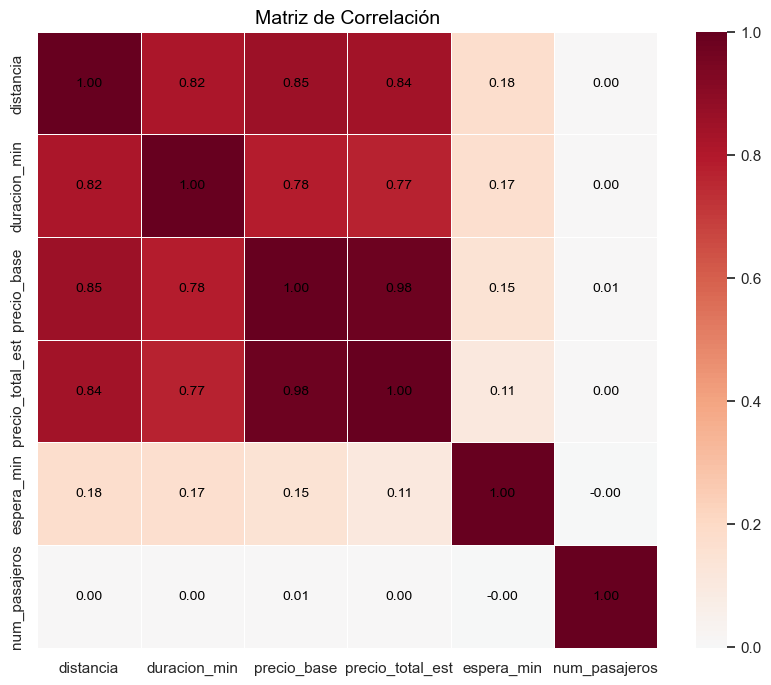

In [20]:
# Creamos una copia para no ensuciar el original
df_corr = df.copy()

#Crear la figura
plt.figure(figsize=(10, 8))
plt.gca().set_facecolor("white")  #Asegurar fondo blanco en la gráfica

#Seleccionar solo las columnas numéricas
cols_numericas = df_corr.select_dtypes(include='number').columns

# Filtramos columnas que no aportan
cols_a_ignorar = ['vendor_id', 'origen_id', 'destino_id', 'Unnamed: 0']
cols_finales = [c for c in cols_numericas if c not in cols_a_ignorar]

#Generar el mapa de calor con una paleta más clara y valores en negro
sns.heatmap(
    df_corr[cols_finales].corr(),
    annot=True,
    cmap="RdBu_r", 
    fmt=".2f",
    linewidths=0.5,  #Líneas separadoras para mejor legibilidad
    center=0,
    annot_kws={"size": 10, "color": "black"}  #Números más grandes y en negro
)

#Ajustar título 
plt.title("Matriz de Correlación", fontsize=14, color="black")

#Mostrar la gráfica
plt.show()

### Detección de Outliers 

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_20832\4088496986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_20832\4088496986.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_20832\4088496986.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


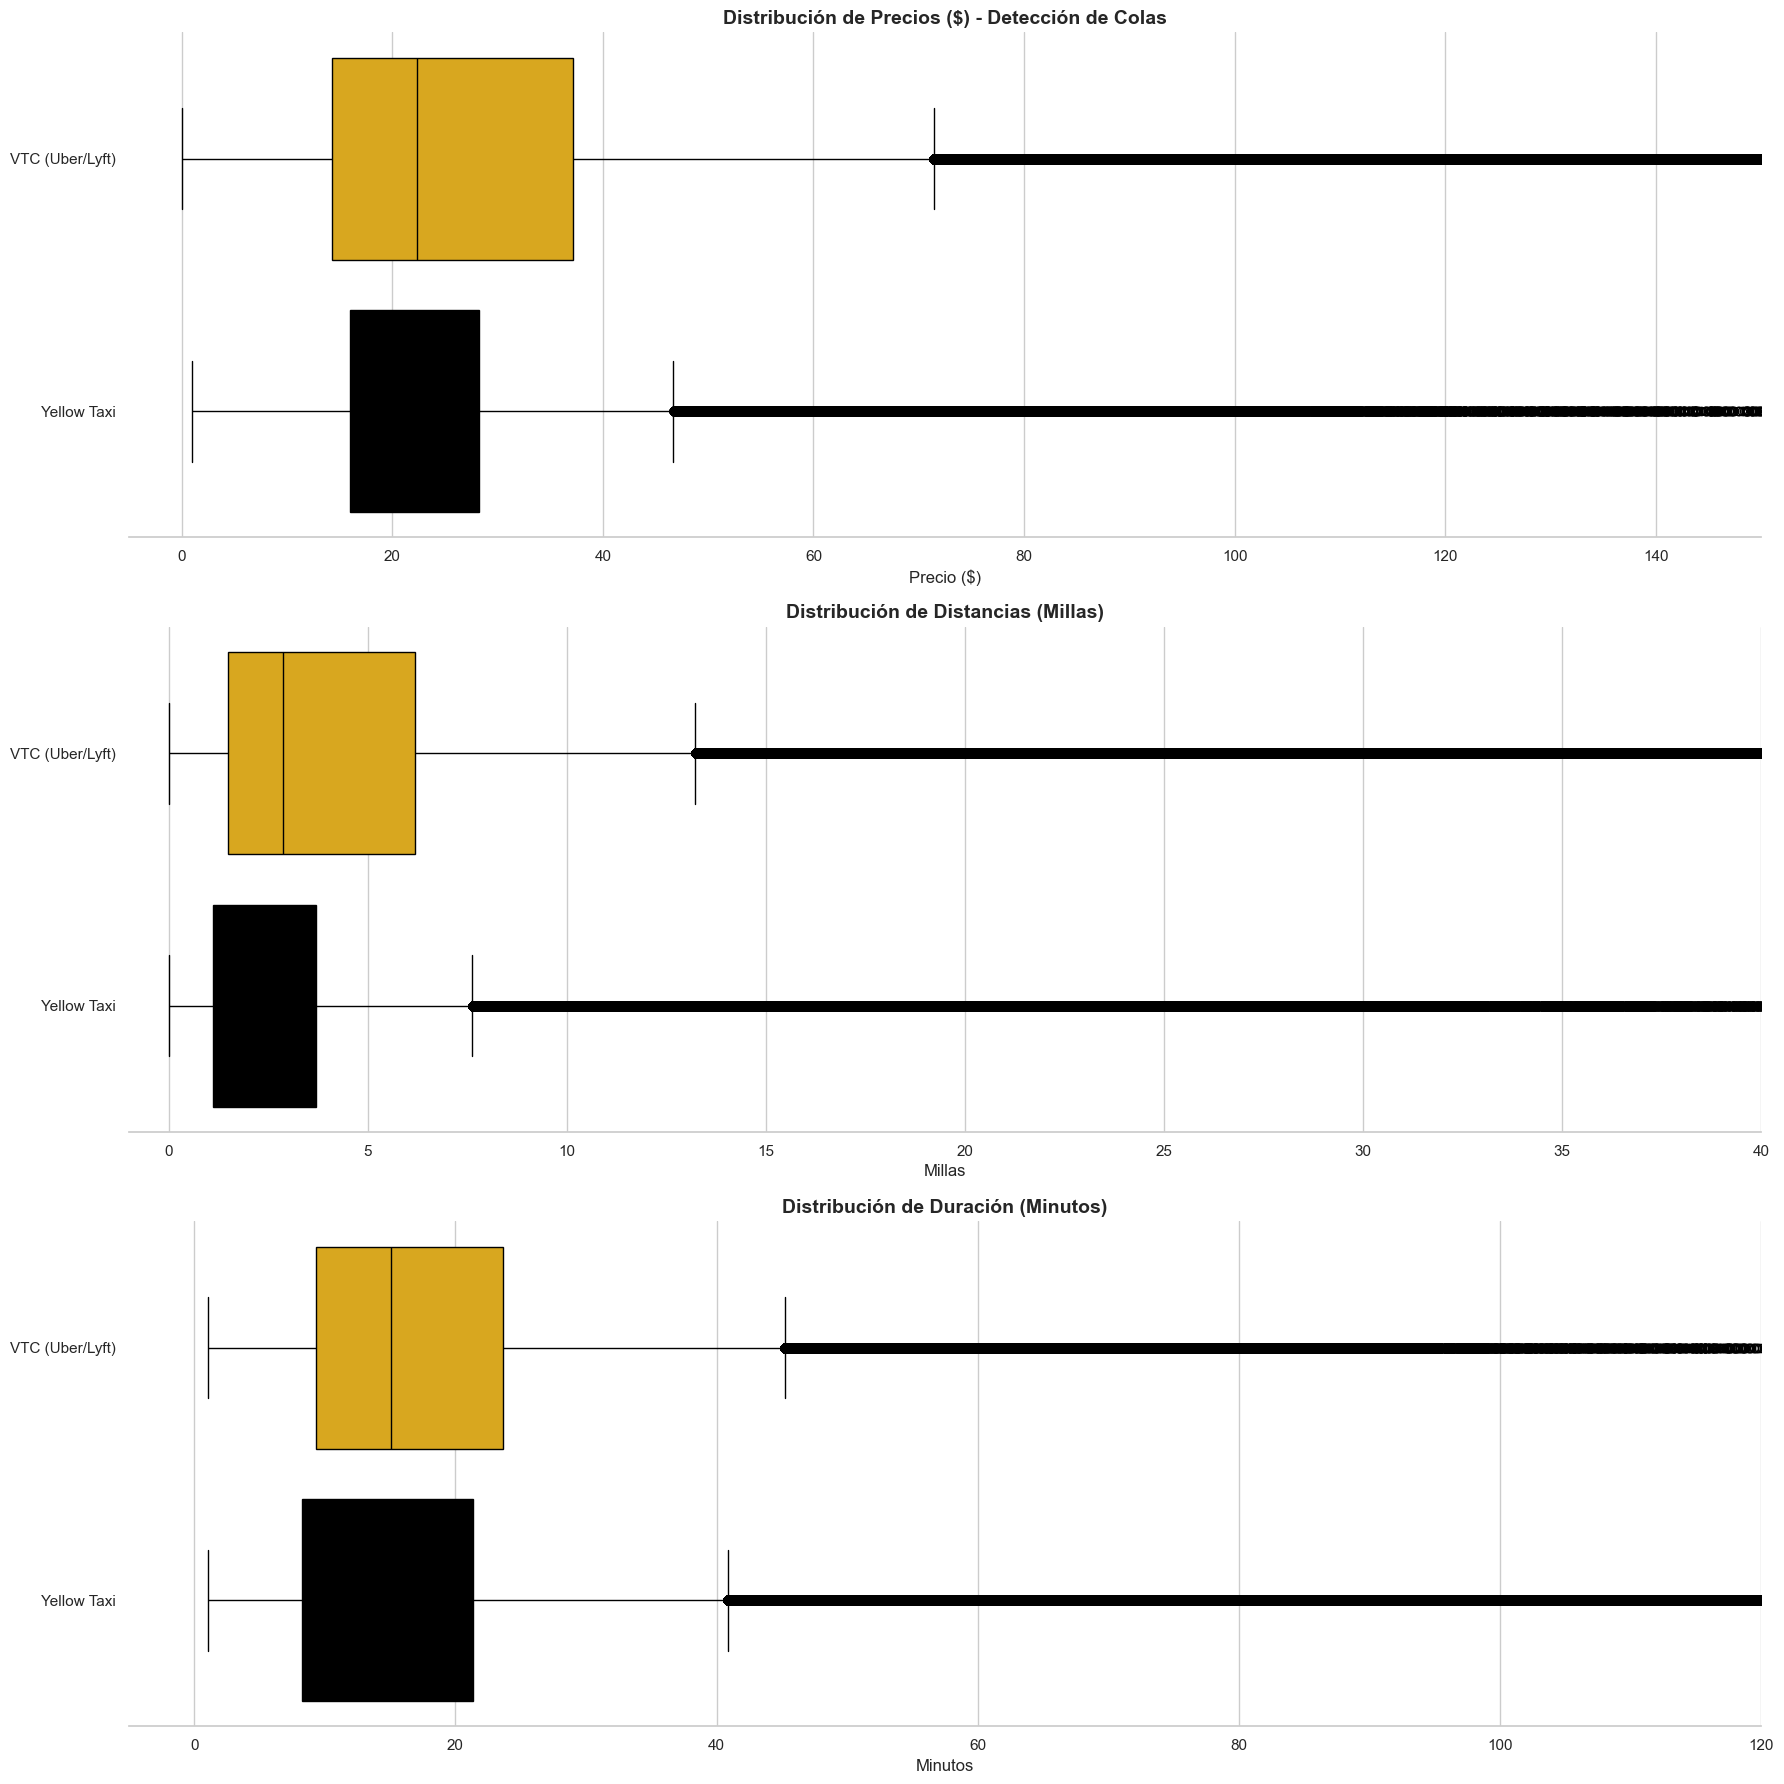

 Detectados 190,681 registros sospechosos.
Criterios: Precio > $150, Distancia < 0.5 millas, Tiempo < 2 min


In [14]:
# --- ANÁLISIS DE OUTLIERS  ---
fig, axes = plt.subplots(3, 1, figsize=(18, 18), sharex=False)
colores = ['#F7B500', 'black']

# Precio
sns.boxplot(
    data=df, 
    x='precio_total_est', # Variable numérica en X
    y='tipo',             # Variable categórica en Y
    ax=axes[0], 
    palette=colores,
    orient='h'            # Orientación horizontal
)
axes[0].set_title("Distribución de Precios ($) - Detección de Colas", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Precio ($)")
axes[0].set_ylabel("") # Quitamos la etiqueta 'tipo' que es obvia
axes[0].set_xlim(-5, 150) # Zoom en la zona interesante (ajusta según tus datos)
sns.despine(ax=axes[0], left=True) 

# Distancia
sns.boxplot(
    data=df, 
    x='distancia', 
    y='tipo', 
    ax=axes[1], 
    palette=colores,
    orient='h'
)
axes[1].set_title("Distribución de Distancias (Millas)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Millas")
axes[1].set_ylabel("")
axes[1].set_xlim(-1, 40) 
sns.despine(ax=axes[1], left=True)

# Duración
sns.boxplot(
    data=df, 
    x='duracion_min', 
    y='tipo', 
    ax=axes[2], 
    palette=colores,
    orient='h'
)
axes[2].set_title("Distribución de Duración (Minutos)", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Minutos")
axes[2].set_ylabel("")
axes[2].set_xlim(-5, 120)
sns.despine(ax=axes[2], left=True)

plt.tight_layout()
plt.show()

limite_precio = 150
limite_distancia = 0.5 # Menos de media milla suele ser error o caminar
limite_tiempo = 2 # Menos de 2 min suele ser cancelación

outliers = df[
    (df.precio_total_est > limite_precio) | 
    (df.distancia < limite_distancia) | 
    (df.duracion_min < limite_tiempo)
]

print(f" Detectados {len(outliers):,} registros sospechosos.")
print("Criterios: Precio > $150, Distancia < 0.5 millas, Tiempo < 2 min")

### Detección de Días Anómalos

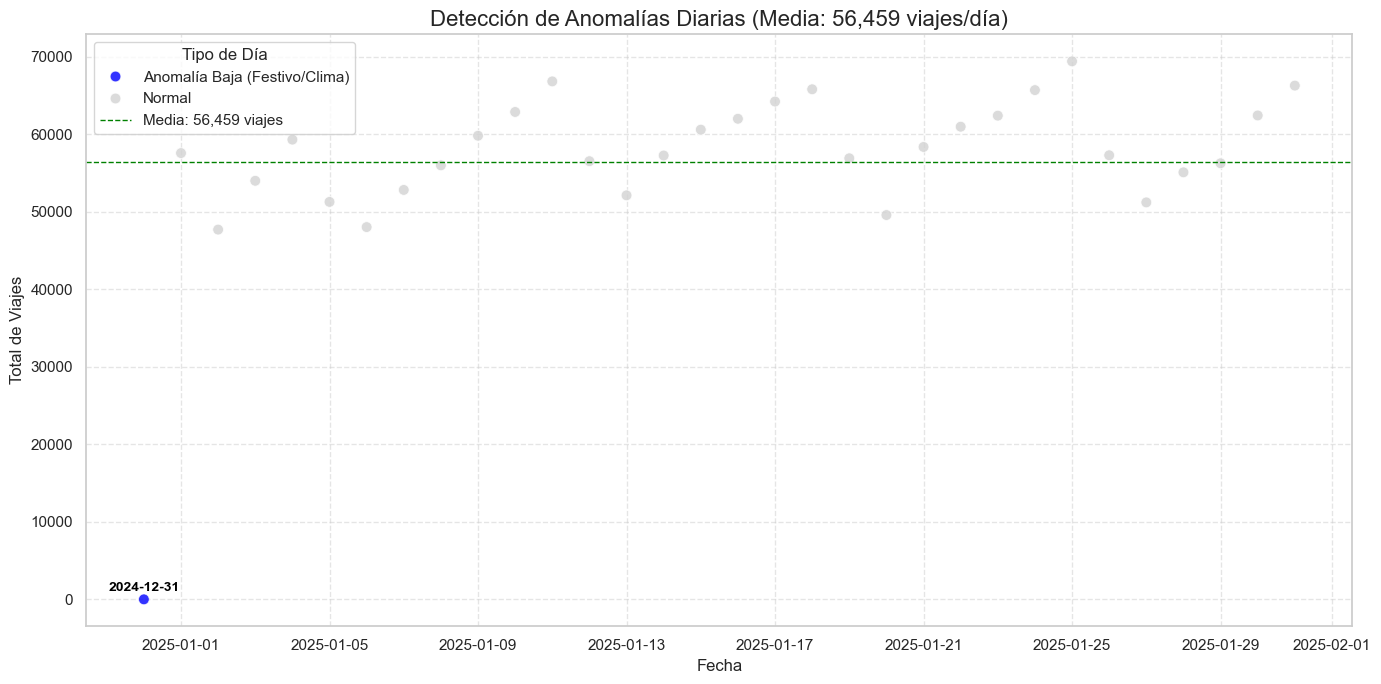

 LA MEDIA DE VIAJES AL DÍA ES: 56,458.78
 Umbral Superior: 79,981 | Umbral Inferior: 32,937

 LISTADO DE DÍAS ANÓMALOS


,fecha_solo,total_viajes,estado
0,2024-12-31,2,Anomalía Baja (Festivo/Clima)


In [21]:
# ---PREPARACIÓN DE DATOS ---
df['fecha_solo'] = df['fecha_inicio'].dt.date
viajes_por_dia = df.groupby('fecha_solo').size().reset_index(name='total_viajes')

# Estadísticas básicas
media_diaria = viajes_por_dia['total_viajes'].mean()
desviacion = viajes_por_dia['total_viajes'].std()

# Definimos los límites (Umbral de 2 desviaciones estándar)
limite_alto = media_diaria + (2 * desviacion)
limite_bajo = media_diaria - (2 * desviacion)

# Etiquetamos cada día para colorearlo después
condiciones = [
    (viajes_por_dia['total_viajes'] > limite_alto),  # Caso Alto
    (viajes_por_dia['total_viajes'] < limite_bajo)   # Caso Bajo
]
opciones = ['Anomalía Alta (Evento)', 'Anomalía Baja (Festivo/Clima)']
viajes_por_dia['estado'] = np.select(condiciones, opciones, default='Normal')

# --- VISUALIZACIÓN MEJORADA (SCATTER PLOT) ---
plt.figure(figsize=(14, 7))

# Pintamos los puntos
sns.scatterplot(
    data=viajes_por_dia, 
    x='fecha_solo', 
    y='total_viajes', 
    hue='estado',  # Colorear según estado
    palette={
        'Normal': 'lightgray', 
        'Anomalía Alta (Evento)': 'red', 
        'Anomalía Baja (Festivo/Clima)': 'blue'
    },
    s=60, # Tamaño del punto
    alpha=0.8
)

# Línea de la media para referencia
plt.axhline(media_diaria, color='green', linestyle='--', linewidth=1, label=f'Media: {media_diaria:,.0f} viajes')

# --- 3. ETIQUETAR LOS PUNTOS EXTREMOS (TEXTO EN EL GRÁFICO) ---
# Filtramos los raros para ponerles nombre en el dibujo
dias_raros = viajes_por_dia[viajes_por_dia['estado'] != 'Normal'].copy()

for _, row in dias_raros.iterrows():
    plt.text(
        row['fecha_solo'], 
        row['total_viajes'] + (media_diaria * 0.02), # Un poquito más arriba del punto
        str(row['fecha_solo']), # Texto a escribir (La fecha)
        horizontalalignment='center',
        size='small',
        color='black',
        weight='bold'
    )

plt.title(f"Detección de Anomalías Diarias (Media: {media_diaria:,.0f} viajes/día)", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Total de Viajes")
plt.legend(title="Tipo de Día")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- RESULTADOS ---
print(f" LA MEDIA DE VIAJES AL DÍA ES: {media_diaria:,.2f}")
print(f" Umbral Superior: {limite_alto:,.0f} | Umbral Inferior: {limite_bajo:,.0f}")
print("\n LISTADO DE DÍAS ANÓMALOS")
display(dias_raros.sort_values('total_viajes', ascending=False))